## Gradient boosting from scratch

Gradient boosting, an powerful squential tree-based learning algorithm. It is aim to boost the overall performance by sequentially updating the results with adding the prediction of each learner. Each learner is bulit by taking the gradient of the previous learner as the target varibles.

In [1]:
## implement both 
from __future__ import division, print_function
import numpy as np

from DecisionTree import RegressionTree, ClassificationTree

class SquareLoss():
## square loss
    def __init__(self): pass

    def loss(self, y, y_pred):
        return 0.5 * np.power((y - y_pred), 2)

    def gradient(self, y, y_pred):
        return -(y - y_pred)

class CrossEntropy():
## cross entropy
    def __init__(self): pass

    def loss(self, y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - y * np.log(p) - (1 - y) * np.log(1 - p)

    def gradient(self, y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - (y / p) + (1 - y) / (1 - p)


class GradientBoosting(object):
    def __init__(self, n_estimators, learning_rate, min_samples_split,
                 min_impurity, max_depth, regression):
    ## initialize hyperparameters
        self.n_estimators = n_estimators
        # number of learners (regression trees)
        self.learning_rate = learning_rate
        # learning rate
        self.min_samples_split = min_samples_split
        # minimum number of sample to split
        self.min_impurity = min_impurity
        # minimum impurity
        self.max_depth = max_depth
        # maximum of depth
        self.regression = regression
        # regression : square loss
        self.loss = SquareLoss()
        
        # classification : cross entropy
        if not self.regression:
            self.loss = CrossEntropy()

        self.trees = []
        for _ in range(n_estimators):
            tree = RegressionTree(
                    min_samples_split=self.min_samples_split,
                    min_impurity=self.min_impurity,
                    max_depth=self.max_depth)
            self.trees.append(tree)


    def fit(self, X, y):
        y_pred = np.full(y.shape, np.mean(y, axis=0))
        
        if self.regression:
            y_pred = np.zeros(y.shape)
        
        for i in range(self.n_estimators):
        ## use gradient as target variable, sequentially update the results by adding the prediction of each learner
            gradient = self.loss.gradient(y, y_pred)
            self.trees[i].fit(X, gradient)
            update = self.trees[i].predict(X)
            update = np.reshape(update, (X.shape[0],-1))
            y_pred -= np.multiply(self.learning_rate, update)


    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for tree in self.trees:
            update = tree.predict(X)
            update = np.multiply(self.learning_rate, update)
            y_pred = -update if not y_pred.any() else y_pred - update


        if not self.regression:
            y_pred = np.exp(y_pred) / np.expand_dims(np.sum(np.exp(y_pred), axis=1), axis=1)
            y_pred = np.argmax(y_pred, axis=1)
        
        return y_pred


class GradientBoostingRegressor(GradientBoosting):
    def __init__(self, n_estimators=10, learning_rate=.5, min_samples_split=2,
                 min_var_red=1e-7, max_depth=5, debug=False):
        super(GradientBoostingRegressor, self).__init__(n_estimators=n_estimators, 
            learning_rate=learning_rate, 
            min_samples_split=min_samples_split, 
            min_impurity=min_var_red,
            max_depth=max_depth,
            regression=True)

class GradientBoostingClassifier(GradientBoosting):
    def __init__(self, n_estimators=10, learning_rate=.5, min_samples_split=2,
                 min_info_gain=1e-7, max_depth=3, debug=False):
        super(GradientBoostingClassifier, self).__init__(n_estimators=n_estimators, 
            learning_rate=learning_rate, 
            min_samples_split=min_samples_split, 
            min_impurity=min_info_gain,
            max_depth=max_depth,
            regression=False)
        
    def _to_categorical(self, x, n_col=None):
        if not n_col:
            n_col = np.amax(x) + 1
        one_hot = np.zeros((x.shape[0], n_col))
        one_hot[np.arange(x.shape[0]), x] = 1
        return one_hot
    
    def fit(self, X, y):
        y = self._to_categorical(y)
        super(GradientBoostingClassifier, self).fit(X, y)

In [2]:
from sklearn.datasets.samples_generator import make_blobs
import random

X_train, y_train = make_blobs(n_samples=50, centers=2,
                  random_state=2, cluster_std=2.50)
    
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

X_test = np.array([[10,10], [20,20], [-10,-10], [-20,-20]])
clf.predict(X_test)

array([1, 1, 0, 0])

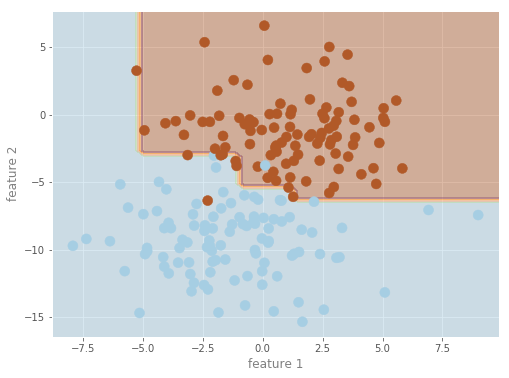

In [3]:
from tools.plot import plot_class
clf = GradientBoostingClassifier()
plot_class(clf)

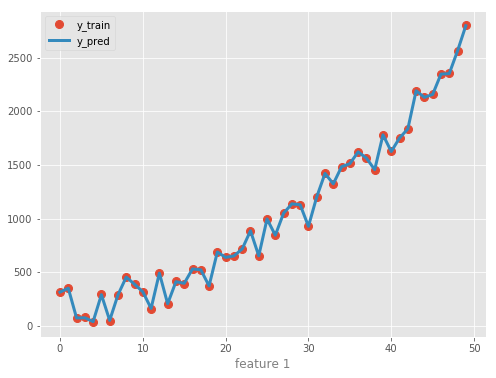

In [4]:
from tools.plot import plot_regressor
reg = GradientBoostingRegressor()
plot_regressor(reg)